### Steps to load Models, make predictions and view predictions

Notice: You may encounter an error while loading the model due to multi GPU compatibility: https://github.com/keras-team/keras/issues/9562

If you see such an error, you can always use Colab and train a new model, for which the code is provided in the notebook.

Step 1- Run the first 12 code cells of the notebook.

Step 2- Go to the last code cell of the notebook. This cell is to load model weights. 

Step 3- Go to second last code cell of the notebook. This cell is to make predictions and load them.

Step 1 note: Don't forget to change pickle paths. This is the path your dataset is loaded from.

Step 2 note: Don't forget to modify "model_path" variable so you can use the shared model weight files. This is the path where your model weights reside in.

Step 3 Note: Don't forget to modify "plot_path" variable. This variable determines where to save the plot.

### Links of the shared data and weight files

__________________________

Links of the shared Weight Files:

250 epochs:

	https://drive.google.com/drive/folders/1xUVIkAGRHxXUhNj-V2-q6M7pnXSn_V4e?usp=sharing


500 epochs:

	https://drive.google.com/drive/folders/1nPecL3pfFkPDTQTnz3PofWWtdk-u3IZF?usp=sharing

______________________

Links of the shared Pickle Files:

	Half Faces:
  
		Ground Truths:

			https://drive.google.com/file/d/1-JVnG_wVJR3VgAwi6-Hhu2C-ZAyQ2-_9/view?usp=sharing

		Occluded Images:
			https://drive.google.com/file/d/1-7E0x-UGFjotUH8UJAWruM9Y0rwEzYzV/view?usp=sharing



	Unrestricted Occlusions:

		Ground Truths:

			https://drive.google.com/file/d/19li26wV60jhrf8UtUhGH6xuocDqiHqPG/view?usp=sharing

		Occluded Images:

			https://drive.google.com/file/d/179YgtbT7A0YFJsQyFULbQPgPZzdmnySA/view?usp=sharing


### The Code

Step 1- Run the first 12 code cells


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, LeakyReLU, Conv2DTranspose, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras import layers
import datetime

from keras import initializers


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory
config.gpu_options.visible_device_list = "0"

set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1 note: Don't forget to change pickle paths.

In [3]:

path = '/content/drive/My Drive/biometrics_data/'
xname = '1_half_face_occluded.pickle'
yname = '1_half_face_labels.pickle'
pickle_in = open(os.path.join(path,xname),"rb")
x = pickle.load(pickle_in)

pickle_in = open(os.path.join(path,yname),"rb")
y = pickle.load(pickle_in)

print(x.shape)
print(y.shape)

(4471, 200, 200, 1)
(4471, 200, 200, 1)


(4471, 64, 64, 1)
(4471, 64, 64, 1)


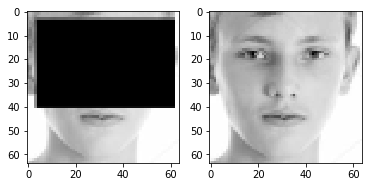

In [4]:
#I use this because with 200,200 images, I exceed GPU memory.

from skimage.transform import resize
x = resize(x, (len(x),64,64,1), anti_aliasing=False)
y = resize(y, (len(y),64,64,1), anti_aliasing=False)

# Print the shape after resize
print(x.shape)
print(y.shape)

#Draw the image to be sure occluded image is the same as the ground truth one
fig=plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(x[1,:,:,0],cmap="gray")
fig.add_subplot(1, 2, 2)
plt.imshow(y[1,:,:,0],cmap="gray")

In [5]:
#I print pixel values to be sure occluded and ground truth images are aligned
print(x[0,0:5,0:5,0])
print(y[0,0:5,0:5,0])

[[0.25130208 0.304856   0.30303309 0.34253983 0.3629136 ]
 [0.27388174 0.32608762 0.34776348 0.36331189 0.38823529]
 [0.23821998 0.30718444 0.32617953 0.38941483 0.38988971]
 [0.27643995 0.32598039 0.35706189 0.36937806 0.41199449]
 [0.2950674  0.32501532 0.3527114  0.38802083 0.40833333]]
[[0.25130208 0.304856   0.30303309 0.34253983 0.3629136 ]
 [0.27388174 0.32608762 0.34776348 0.36331189 0.38823529]
 [0.23821998 0.30718444 0.32617953 0.38941483 0.38988971]
 [0.27643995 0.32598039 0.35706189 0.36937806 0.41199449]
 [0.2950674  0.32501532 0.3527114  0.38802083 0.40833333]]


In [6]:
#Here is the function to create a generator. I also use the function and create a generator in the same cell.
def creategen():
  generator = Sequential()


  generator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))


  generator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  
  generator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  generator.add(BatchNormalization())
  generator.add(ReLU())  
  generator.add(Dropout(0.3))

  # I would use these if there was a bottleneck in the network.
  #generator.add(Flatten())
  
  #generator.add(Dense(64)) 
  #generator.add(BatchNormalization())
  #generator.add(ReLU(alpha=0.2))
  
  #generator.add(Dense(8*8*128)) 
  #generator.add(BatchNormalization())
  #generator.add(ReLU(alpha=0.2))
  
  #generator.add(layers.Reshape((8,8,128)))


  generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  
  generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation = "tanh"))
  

  return generator

generator = creategen()



W0615 12:59:44.105421 140624213170048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0615 12:59:44.566210 140624213170048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#Here is the function to create a discriminator. 
#I also use the function and create a discriminator in the same cell.
def createdisc():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (5,5) , strides = (2,2), input_shape = x.shape[1:] , padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))


  discriminator.add(Conv2D(128, (5,5) ,  strides = (2,2),padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Conv2D(256, (5,5) ,  strides = (2,2), padding = "SAME",kernel_initializer = 'random_normal'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.3))

  
  discriminator.add(Flatten())
  discriminator.add(Dense(1))
  
  return discriminator


discriminator = createdisc()



In [8]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [9]:
# Learning rate of discriminator is advised to be the double of the generator. 
# I train the generator two times in each step of training. First is with Gan loss, second is with L2 loss.
# That is why I use x4 learning rate in discriminator.

opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)      

In [10]:
opt_gen = Adam(lr=0.00001)
generator.compile(loss='mean_squared_error', optimizer = opt_gen)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0

In [0]:
#Here is the function to create a GAN model. I also use the function and create GAN model in the same cell.

def creategan(generator,discriminator):
  gan = Sequential()
  gan.add(generator)
  discriminator.trainable = False
  gan.add(discriminator)
  return(gan)

gan = creategan(generator,discriminator)

In [12]:
opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         2054208   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1044225   
Total params: 3,098,433
Trainable params: 2,052,928
Non-trainable params: 1,045,505
_________________________________________________________________


In [0]:
# This is to save models. It saves both the architectures and the weights.
# While loading the model, you will only need weights since you declared the architecture in the previous cells.

def save_models(gan,discriminator,generator,path,epoch):
  datenow = str(datetime.datetime.now().strftime('%m-%d-%H:%M'))
  gan.save_weights(os.path.join(path,"{0}_wgan_{1}.h5".format(epoch,datenow)))
  gan.save(os.path.join(path,"{0}_mgan_{1}.h5".format(epoch,datenow)))


  discriminator.save_weights(os.path.join(path,"{0}_wd_{1}.h5".format(epoch,datenow)))
  discriminator.save(os.path.join(path,"{0}_md_{1}.h5".format(epoch,datenow)))


  generator.save_weights(os.path.join(path,"{0}_wg_{1}.h5".format(epoch,datenow)))
  generator.save(os.path.join(path,"{0}_mg_{1}.h5".format(epoch,datenow)))
  

  


In [0]:
# This is to obtain test losses in each training step. I use this function in the "train" function.
def test(x,y):
  gan_inp_t = x  
  gan_label_t = np.ones([len(gan_inp_t)])
  gan_predict_t = None
  
  disc_inp_t = None


  disc_label_t = np.zeros([len(gan_inp_t)*2])
  disc_label_t[len(gan_inp_t):] = 1
  
  disc_predict_t = None
  

  gen_predict_t = generator.predict(gan_inp_t)


  disc_inp_t = np.concatenate((gen_predict_t,y), axis = 0)
  disc_predict_t = discriminator.predict(disc_inp_t)

  d_loss_t = discriminator.test_on_batch(disc_inp_t,disc_label_t)

  gan_loss_t = gan.test_on_batch(gan_inp_t,gan_label_t)
  
  return (gan_loss_t, d_loss_t)

In [0]:
# In the previous versions, I used this function to pretrain the discriminator in each training step.
# I do not use this function in this version.
def pretrain(x,y,nepoch):
    
  gen_predict = None
  
  
  gan_inp = x  
  gan_label = np.ones(64)
  gan_predict = None
  
  disc_inp = None


  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  
  
  for epoch in range(nepoch):
    for batch_ctr in range(65):


      gen_predict = generator.predict(gan_inp[batch_ctr*64:(batch_ctr+1)*64])


      disc_inp = np.concatenate((gen_predict,y[batch_ctr*64:(batch_ctr+1)*64]), axis = 0)
      disc_predict = discriminator.predict(disc_inp)



      d_loss = discriminator.train_on_batch(disc_inp,disc_label)


      gan_loss = gan.test_on_batch(gan_inp[batch_ctr*64:(batch_ctr+1)*64],
                                    gan_label)
    

    (tgan,tdisc)= test(x[4160:],y[4160:])
    print("Pretrain Epoch Gan Loss: {0}       Disc Loss: {1}".format(gan_loss,d_loss))
    print("Pretrain Epoch Test Gan Loss: {0}  Test Disc Loss: {1} \n\n\n".format(tgan,tdisc))

In [0]:
# I use isolated mini batches to slow down discriminator:
# I also use smooth/noisy labels proposed by Salimans et al 2016
# Reference: https://github.com/soumith/ganhacks



def train(x,y, nepoch, model_save_path = "/content/drive/My Drive/biometrics_data/models/dummymodel"):

  gen_predict = None
  
  #Initialize the inputs and the labels.
  gan_inp = x  
  gan_label = np.ones(64)
  gan_predict = None
  
  disc_inp = None


  disc_label = np.zeros(64*2)
  disc_label[64:] = 1
  
  disc_predict = None
  

  sess = tf.Session()
  

  for epoch in range(nepoch):

    for batch_ctr in range(65):

      #Generator makes a prediction.
      gen_predict = generator.predict(gan_inp[batch_ctr*64:(batch_ctr+1)*64])


      #Minibatch isolation and label smoothing is done here:
      
      if(epoch%2==0):
        disc_inp = gen_predict
        #disc_label = np.zeros(64) //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=0, scale=0.10, size=64)
      else:
        disc_inp = y[batch_ctr*64:(batch_ctr+1)*64]
        #disc_label = np.ones(64)  //// I would use this line if there was no noisy labels.
        disc_label = np.random.normal(loc=1, scale=0.10, size=64)


        
      #Initialize a label variable for generator to use it in training.  
      gen_label = y[batch_ctr*64:(batch_ctr+1)*64]
      
      
      #Do one training step. Also assign the losses to variables. We will print them.
      d_loss = discriminator.train_on_batch(disc_inp,disc_label)


      gan_loss = gan.train_on_batch(gan_inp[batch_ctr*64:(batch_ctr+1)*64],
                                    gan_label)

      gen_loss = generator.train_on_batch(gan_inp[batch_ctr*64:(batch_ctr+1)*64],gen_label)
      
    
    
    if epoch+1%500 == 0:
      save_models(gan,discriminator,generator, model_save_path,epoch+1)  
      print("MODEL SAVED")
      
    
    # Test images are the images after the 4160th image. It makes 311 test images.
    (tgan,tdisc)= test(x[4160:],y[4160:])
    print("Epoch: {2} Gan Loss: {0}       Disc Loss: {1}        Gen Loss: {3}".format(gan_loss,d_loss,epoch+1,gen_loss))
    print("Epoch: {2} Test Gan Loss: {0}  Test Disc Loss: {1} \n\n\n".format(tgan,tdisc,epoch+1))

In [17]:
# Checking lengths of the input and ground truth arrays. Also checking if normalization is done.
print(len(x),len(y))
print(x.max(),x.min())
print(y.max(),y.min())


4471 4471
1.0 0.0
1.0 0.0


If you would like to make trainings, don't forget to modify "model_save_path" variable.

In [18]:
# Use this cell if you have loaded and viewed the results, and want to train further.
# If you start the model from beginning, using above cells where I declare 
# generator architecture, discriminator architecture etc. , you don't need to use this cell since
# I already compile the models in above cells.


# Learning rate of discriminator is advised to be the double of the generator. 
# I train the generator two times in each step of training. First is with Gan loss, second is with L2 loss.
# That is why I use x4 learning rate in discriminator.

"""opt_disc = Adam(lr=0.00004)
discriminator.trainable = True
discriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)
discriminator.summary()

opt_gen = Adam(lr=0.00001)
generator.compile(loss='mean_squared_error', optimizer = opt_gen)
generator.summary()

opt_gan = Adam(lr=0.00001)
gan.compile(loss = "binary_crossentropy", optimizer = opt_gan)
gan.summary()"""

'opt_disc = Adam(lr=0.00004)\ndiscriminator.trainable = True\ndiscriminator.compile(loss = "binary_crossentropy", optimizer = opt_disc)\ndiscriminator.summary()\n\nopt_gen = Adam(lr=0.00001)\ngenerator.compile(loss=\'mean_squared_error\', optimizer = opt_gen)\ngenerator.summary()\n\nopt_gan = Adam(lr=0.00001)\ngan.compile(loss = "binary_crossentropy", optimizer = opt_gan)\ngan.summary()'

In [19]:
# To train, don't forget to:
# -compile the models
# - run the necessary cells to declare the necessary functions such as "train" and "save_models" and "test"

#If you train models from beginning, just run the cells of the notebook in order.

#If you want to further train loaded models, use the previous cell to compile models.

model_save_path = "/content/drive/My Drive/biometrics_data/models/half_face"
batch_size = 64
train(x,y,504,model_save_path)

W0615 12:59:49.312861 140624213170048 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0615 12:59:49.426358 140624213170048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1 Gan Loss: 15.424948692321777       Disc Loss: 0.02699965238571167        Gen Loss: 0.33917707204818726
Epoch: 1 Test Gan Loss: 15.424947738647461  Test Disc Loss: 7.67417049407959 



Epoch: 2 Gan Loss: 0.31460461020469666       Disc Loss: -0.003959421068429947        Gen Loss: 0.19448310136795044
Epoch: 2 Test Gan Loss: 1.8346877098083496  Test Disc Loss: 0.0897170677781105 



Epoch: 3 Gan Loss: 7.74964714050293       Disc Loss: 0.46623095870018005        Gen Loss: 0.11904726922512054
Epoch: 3 Test Gan Loss: 6.344828128814697  Test Disc Loss: 0.031923647969961166 



Epoch: 4 Gan Loss: 0.5525617599487305       Disc Loss: 0.1054864227771759        Gen Loss: 0.07899534702301025
Epoch: 4 Test Gan Loss: 1.0162090063095093  Test Disc Loss: 0.2520448863506317 



Epoch: 5 Gan Loss: 13.94118881225586       Disc Loss: 0.21348145604133606        Gen Loss: 0.05697213113307953
Epoch: 5 Test Gan Loss: 2.1777305603027344  Test Disc Loss: 0.5405696630477905 



Epoch: 6 Gan Loss: 1.165234

KeyboardInterrupt: ignored

Step 3 - Make predictions and view them.

Step 3 Note: Don't forget to modify "plot_path" variable. This variable determines where to save the plot.

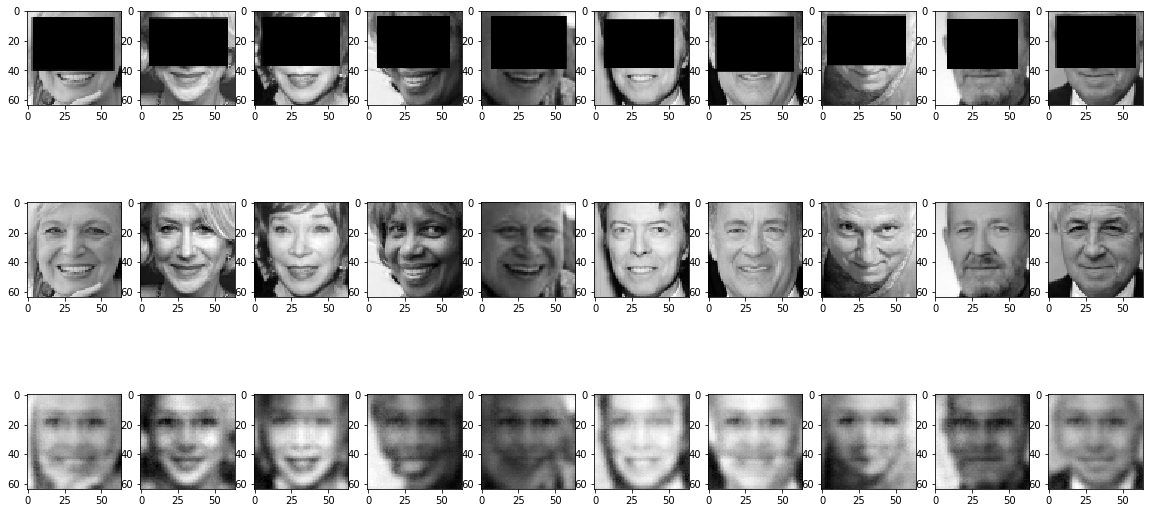

In [21]:
#Making predictions and drawing them.
#First row: Occluded images
#Second row: Ground Truth images
#Third row: Predictions

import datetime
plot_path = "/content/drive/My Drive/biometrics_data/plots/half_face"

a = 4160
b = 4170
pred=generator.predict(x[a:b])

fig = plt.figure(figsize = (20,10))
for ctr in range(10):
  fig.add_subplot(3,10,ctr+1)
  plt.imshow(np.reshape(x[a + ctr],(64,64)),  cmap = "gray")

  

for ctr in range(10):
  fig.add_subplot(3,10,(10 + ctr + 1))
  plt.imshow(np.reshape(y[a + ctr]/255,(64,64)),  cmap = "gray")  


for ctr in range(10):
  fig.add_subplot(3,10,(20 + ctr + 1))
  plt.imshow(np.reshape(pred[ctr],(64,64)),  cmap = "gray")
  
#plt.savefig(os.path.join(plot_path,str(datetime.datetime.now().strftime('%m-%d-%H:%M'))))

Step 2- Load weights here:
(Don't forget to modify the model_path)

You may encounter an error while loading the model due to multi GPU compatibility: https://github.com/keras-team/keras/issues/9562

If you see such an error, you can always use Colab and train a new model. (Don't forget to use GPU.)

The code to train the model exists in this notebook.

In [15]:
model_path = "/content/drive/My Drive/biometrics_data/models/last_experiment_500/"

epoch = 500



#generator = creategen()
generator.load_weights(os.path.join(model_path,"{0}_wg.h5".format(epoch)))
#discriminator = createdisc()
discriminator.load_weights(os.path.join(model_path,"{0}_wd.h5".format(epoch)))


#gan = creategan(generator,discriminator)
gan.load_weights(os.path.join(model_path,"{0}_wgan.h5".format(epoch)))

ValueError: ignored